In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pwlf
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [35]:
df_chile = pd.read_csv('data/chile.list', sep=' ', names=['distance', 'depth'])
df_chile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   distance  239 non-null    float64
 1   depth     239 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 3.9 KB


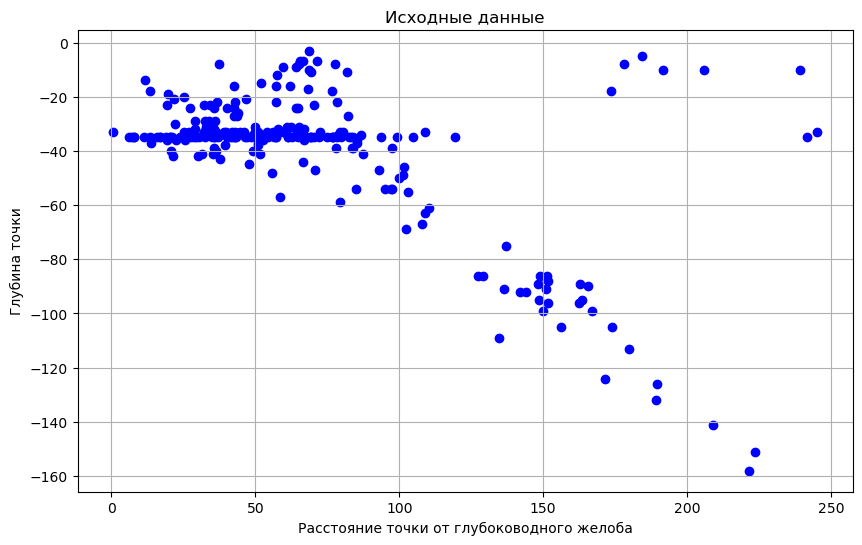

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(df_chile.distance, df_chile.depth, color='blue')
plt.xlabel('Расстояние точки от глубоководного желоба')
plt.ylabel('Глубина точки')
plt.title('Исходные данные')
plt.grid();

In [37]:
# Стандартизация исходных данных

std_scaler = StandardScaler()
std_scaler.fit(df_chile)
std_scaled = std_scaler.transform(df_chile)
df_chile[['std_scaled_distance', 'std_scaled_depth']] = std_scaled

# Средние и масштабы для обратного преобразования
mu_X = std_scaler.mean_[0]
sigma_X = std_scaler.scale_[0]
mu_y = std_scaler.mean_[1]
sigma_y = std_scaler.scale_[1]

df_chile

,distance,depth,std_scaled_distance,std_scaled_depth
0,0.499345,-33,-1.406111,0.304646
1,6.172528,-35,-1.294173,0.229117
2,7.186904,-35,-1.274158,0.229117
3,7.704549,-35,-1.263945,0.229117
4,7.819581,-35,-1.261675,0.229117
...,...,...,...,...
234,221.468527,-158,2.953845,-4.415948
235,223.661983,-151,2.997124,-4.151595
236,239.173042,-10,3.303173,1.173236
237,241.669765,-35,3.352436,0.229117


In [38]:
X = df_chile[['std_scaled_distance']]
y = df_chile['std_scaled_depth']

degree = 2 # Степень полинома для полиномиальных признаков
poly_feature = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly_feature.fit_transform(X)

# Создание модели робастной регрессии
huber = HuberRegressor()

# Определение распределения гиперпараметров для поиска
param_distributions_huber = {
    'epsilon': uniform(1.0, 2.0),
    'max_iter': [100, 200, 300, 400, 500],
    'alpha': uniform(0.0001, 0.01)
}
# Поиск лучших гиперпараметров
random_search_huber = RandomizedSearchCV(huber, param_distributions_huber, n_iter=100, cv=5, random_state=42)
random_search_huber.fit(X_poly, y)
print("Лучшие параметры:", random_search_huber.best_params_)

Лучшие параметры: {'alpha': 0.00460499251969543, 'epsilon': 1.026529922319733, 'max_iter': 100}


Коэффициенты: [-0.2456245  -0.19125782]
Свободный член: 23.53519277465975


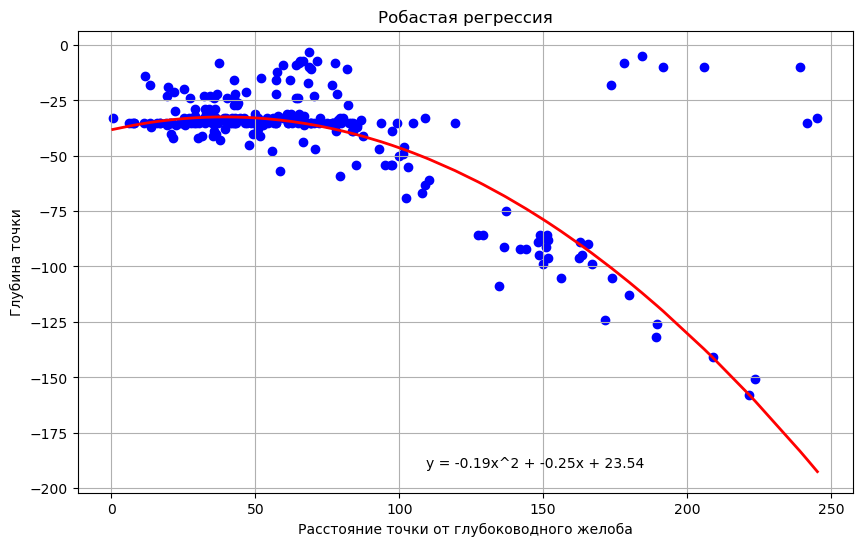

In [39]:
# Создание окончательной модели с лучшими гиперпараметрами
huber = HuberRegressor(**random_search_huber.best_params_)
huber.fit(X_poly, y)

# Предсказывание значений с помощью обученной модели
pred_huber = huber.predict(X_poly)

# Получение коэффициентов модели и независимого члена
coefficients_huber = huber.coef_
intercept_huber = huber.intercept_

# Преобразование предсказанных значений обратно в исходный масштаб
pred_huber_original = pred_huber * sigma_y + mu_y

# Преобразование коэффициентов и свободного члена в исходный масштаб
coefficients_huber_original = coefficients_huber * (sigma_y / sigma_X)
intercept_huber_original = intercept_huber * sigma_y + mu_y - (coefficients_huber * mu_X).sum()

print("Коэффициенты:", coefficients_huber_original)
print("Свободный член:", intercept_huber_original)

# Визуализиция данных и модели

formula_text_huber = f'y = {coefficients_huber_original[1]:.2f}x^2 + {coefficients_huber_original[0]:.2f}x + {intercept_huber_original:.2f}'

plt.figure(figsize=(10, 6))
plt.scatter(X * sigma_X + mu_X, y * sigma_y + mu_y, color='blue')
plt.plot(X * sigma_X + mu_X, pred_huber_original, color='red', linewidth=2)
plt.text(0.45, 0.08, formula_text_huber, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel('Расстояние точки от глубоководного желоба')
plt.ylabel('Глубина точки')
plt.title('Робастая регрессия')
plt.grid()
plt.show();

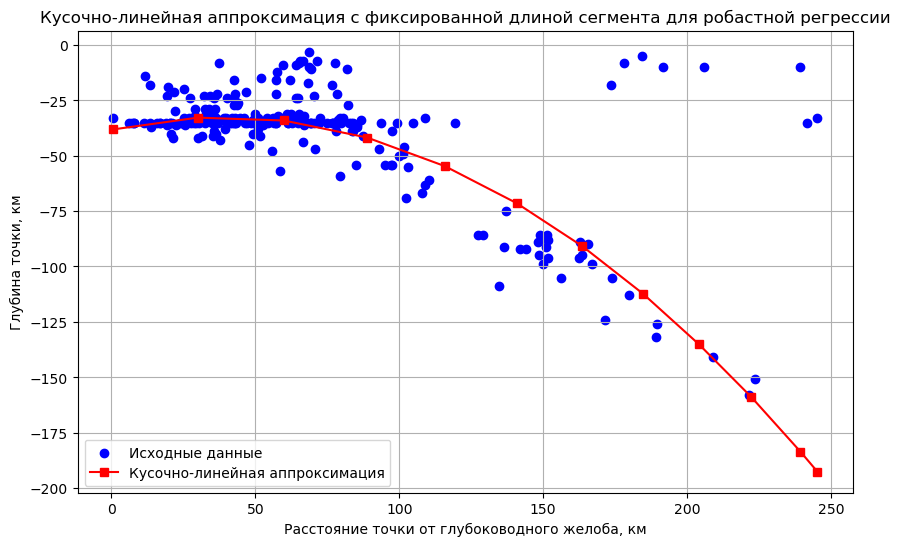

Угол наклона сегмента 0: 10.26 градусов.
Угол наклона сегмента 1: -2.46 градусов.
Угол наклона сегмента 2: -14.89 градусов.
Угол наклона сегмента 3: -25.55 градусов.
Угол наклона сегмента 4: -33.82 градусов.
Угол наклона сегмента 5: -40.42 градусов.
Угол наклона сегмента 6: -45.51 градусов.
Угол наклона сегмента 7: -49.59 градусов.
Угол наклона сегмента 8: -52.61 градусов.
Угол наклона сегмента 9: -55.33 градусов.
Угол наклона сегмента 10: -56.87 градусов.


In [40]:
# Длина сегмента для кусочно-линейной аппроксимации
segment_length = 30

# Применение скаляризации к данным
X_appr = X.values.flatten() * sigma_X + mu_X
y_appr_huber = pred_huber_original 

# Функция для вычисления евклидова расстояния между двумя точками
def euclidean_distance(p1, p2):
    return np.linalg.norm(p1 - p2)

# Функция для кусочно-линейной аппроксимации
def approximation(X_appr, y_appr, segment_length):
    nodes = [(X_appr[0], y_appr[0])]
    total_distance = 0.0
    current_node = np.array(nodes[0])
    
    for i in range(1, len(X_appr)):
        next_point = np.array([X_appr[i], y_appr[i]])
        dist = euclidean_distance(current_node, next_point)
        
        while total_distance + dist >= segment_length:
            ratio = (segment_length - total_distance) / dist
            new_node = current_node + ratio * (next_point - current_node)
            nodes.append(tuple(new_node))
            current_node = new_node
            total_distance = 0.0
            dist = euclidean_distance(current_node, next_point)
        
        total_distance += dist
        current_node = next_point
   
    nodes.append((X_appr[-1], y_appr[-1]))  # Добавляем последний узел

    angles = [np.arctan2(nodes[i + 1][1] - nodes[i][1], nodes[i + 1][0] - nodes[i][0])
              for i in range(len(nodes) - 1)]
    
    return zip(*nodes), angles

# Применение аппроксимации для робастой регрессии
(hx_huber, hy_huber), angles_huber = approximation(X_appr, y_appr_huber, segment_length)

# Визуализация результатов аппроксимации
plt.figure(figsize=(10, 6))
plt.scatter(X * sigma_X + mu_X, y * sigma_y + mu_y, color='blue', label='Исходные данные')
plt.plot(hx_huber, hy_huber, 'rs-', label='Кусочно-линейная аппроксимация')
plt.title('Кусочно-линейная аппроксимация с фиксированной длиной сегмента для робастной регрессии')
plt.xlabel('Расстояние точки от глубоководного желоба, км')
plt.ylabel('Глубина точки, км')
plt.legend()
plt.grid()
plt.show()

# Вывод углов наклона сегментов
for i, angle in enumerate(angles_huber):
    print(f"Угол наклона сегмента {i}: {np.degrees(angle):.2f} градусов.")

In [41]:
# Создание модели неробастной (линейной) регрессии
lin_reg = LinearRegression()

# Определение распределения гиперпараметров для поиска
param_distributions = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [None, -1, 1],
    'positive': [True, False]
}

# Поиск лучших гиперпараметров
random_search_lin_reg = RandomizedSearchCV(lin_reg, param_distributions, n_iter=10, cv=5, random_state=42)
random_search_lin_reg.fit(X_poly, y)
print("Лучшие параметры:", random_search_lin_reg.best_params_)

Лучшие параметры: {'positive': True, 'n_jobs': -1, 'fit_intercept': False, 'copy_X': True}


Коэффициенты: [0. 0.]
Свободный член: -41.06694560669456


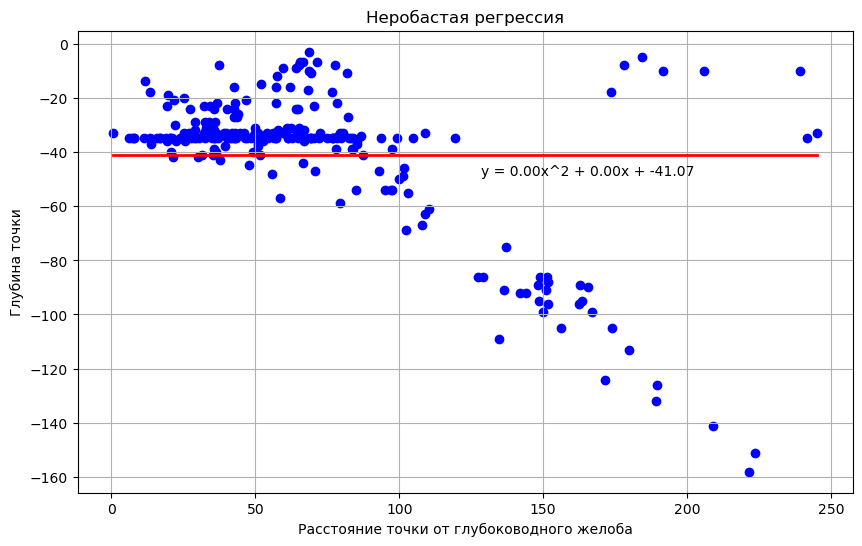

In [42]:
# Создание окончательной модели с лучшими гиперпараметрами
lin_reg = LinearRegression(**random_search_lin_reg.best_params_)
lin_reg.fit(X_poly, y)

# Предсказывание значений с помощью обученной модели
pred_lin_reg = lin_reg.predict(X_poly)

# Преобразование предсказанных значений обратно в исходный масштаб
pred_lin_reg_original = pred_lin_reg * sigma_y + mu_y

# Преобразование коэффициентов и свободного члена в исходный масштаб
coefficients_lin_reg = lin_reg.coef_ * (sigma_y / sigma_X)
intercept_lin_reg_original = lin_reg.intercept_ * sigma_y + mu_y - (coefficients_lin_reg * mu_X).sum()

print("Коэффициенты:", coefficients_lin_reg)
print("Свободный член:", intercept_lin_reg_original)

# Визуализация результатов линейной регрессии

formula_text_lin_reg = f'y = {coefficients_lin_reg[1]:.2f}x^2 + {coefficients_lin_reg[0]:.2f}x + {intercept_lin_reg_original:.2f}'

plt.figure(figsize=(10, 6))
plt.scatter(X * sigma_X + mu_X, y * sigma_y + mu_y, color='blue')
plt.plot(X * sigma_X + mu_X, pred_lin_reg_original, color='red', linewidth=2)
plt.text(0.52, 0.71, formula_text_lin_reg, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel('Расстояние точки от глубоководного желоба')
plt.ylabel('Глубина точки')
plt.title('Неробастая регрессия')
plt.grid()
plt.show()

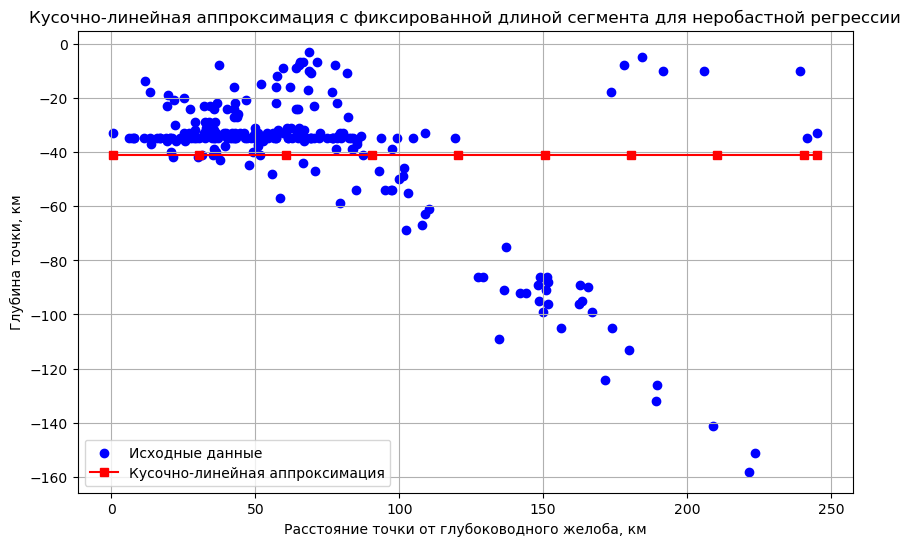

Угол наклона сегмента 0: 0.00 градусов.
Угол наклона сегмента 1: 0.00 градусов.
Угол наклона сегмента 2: 0.00 градусов.
Угол наклона сегмента 3: 0.00 градусов.
Угол наклона сегмента 4: 0.00 градусов.
Угол наклона сегмента 5: 0.00 градусов.
Угол наклона сегмента 6: 0.00 градусов.
Угол наклона сегмента 7: 0.00 градусов.
Угол наклона сегмента 8: 0.00 градусов.


In [43]:
# Применение аппроксимации для неробастой (линейной) регрессии
(hx_lin_reg, hy_lin_reg), angles_lin_reg = approximation(X_appr, pred_lin_reg_original, segment_length)

# Визуализация результатов аппроксимации
plt.figure(figsize=(10, 6))
plt.scatter(X * sigma_X + mu_X, y * sigma_y + mu_y, color='blue', label='Исходные данные')
plt.plot(hx_lin_reg, hy_lin_reg, 'rs-', label='Кусочно-линейная аппроксимация')
plt.xlabel('Расстояние точки от глубоководного желоба, км')
plt.ylabel('Глубина точки, км')
plt.title('Кусочно-линейная аппроксимация с фиксированной длиной сегмента для неробастной регрессии')
plt.legend()
plt.grid()
plt.show()

# Вывод углов наклона сегментов
for i, angle in enumerate(angles_lin_reg):
    print(f"Угол наклона сегмента {i}: {np.degrees(angle):.2f} градусов.")

In [44]:
# Фильтрация данных (исключение данных с глубинами 33 и 35 км)
df_chile_cleaned = df_chile[(df_chile.depth != -33) & (df_chile.depth != -35)]

X_cleaned = df_chile_cleaned[['std_scaled_distance']]
y_cleaned = df_chile_cleaned['std_scaled_depth']

poly_features_cleaned = PolynomialFeatures(degree=degree, include_bias=False)
X_cleaned_poly = poly_features_cleaned.fit_transform(X_cleaned)

# Создание модели робастной регрессии
huber_cleaned = HuberRegressor()

# Поиск лучших гиперпараметров
random_search_huber_cleaned = RandomizedSearchCV(huber_cleaned, param_distributions_huber, n_iter=100, cv=5, random_state=42)
random_search_huber_cleaned.fit(X_cleaned_poly, y_cleaned)
print("Лучшие параметры:", random_search_huber_cleaned.best_params_)

Лучшие параметры: {'alpha': 0.006576901205413624, 'epsilon': 1.0010407539906316, 'max_iter': 500}


Коэффициенты: [-0.40449131 -0.1375213 ]
Свободный член: 37.81433930641239


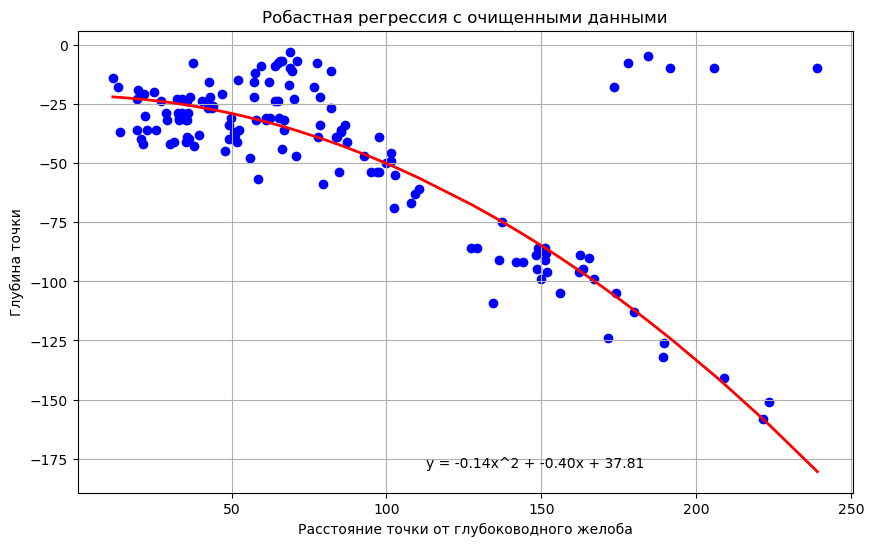

In [47]:
# Создание окончательной модели с лучшими гиперпараметрами
huber_cleaned = HuberRegressor(**random_search_huber_cleaned.best_params_)
huber_cleaned.fit(X_cleaned_poly, y_cleaned)

# Предсказывание значений с помощью обученной модели
pred_huber_cleaned = huber_cleaned.predict(X_cleaned_poly)

# Получение коэффициентов модели и независимого члена
coefficients_huber_cleaned = huber_cleaned.coef_
intercept_huber_cleaned = huber_cleaned.intercept_

# Преобразование значений X обратно в исходный масштаб
X_cleaned_original = X_cleaned.values.flatten() * sigma_X + mu_X

# Преобразование предсказанных значений обратно в исходный масштаб
pred_huber_cleaned_original = pred_huber_cleaned * sigma_y + mu_y

# Преобразование коэффициентов и свободного члена в исходный масштаб
coefficients_huber_cleaned_original = coefficients_huber_cleaned * (sigma_y / sigma_X)
intercept_huber_cleaned_original = intercept_huber_cleaned * sigma_y + mu_y - (coefficients_huber_cleaned * mu_X).sum()

print("Коэффициенты:", coefficients_huber_cleaned_original)
print("Свободный член:", intercept_huber_cleaned_original)

# Визуализация данных и модели

formula_text_huber_cleaned = f'y = {coefficients_huber_cleaned_original[1]:.2f}x^2 + {coefficients_huber_cleaned_original[0]:.2f}x + {intercept_huber_cleaned_original:.2f}'

plt.figure(figsize=(10, 6))
plt.scatter(X_cleaned * sigma_X + mu_X, y_cleaned * sigma_y + mu_y, color='blue')
plt.plot(X_cleaned * sigma_X + mu_X, pred_huber_cleaned_original, color='red', linewidth=2)
plt.text(0.45, 0.08, formula_text_huber_cleaned, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel('Расстояние точки от глубоководного желоба')
plt.ylabel('Глубина точки')
plt.title('Робастная регрессия с очищенными данными')
plt.grid()
plt.show();

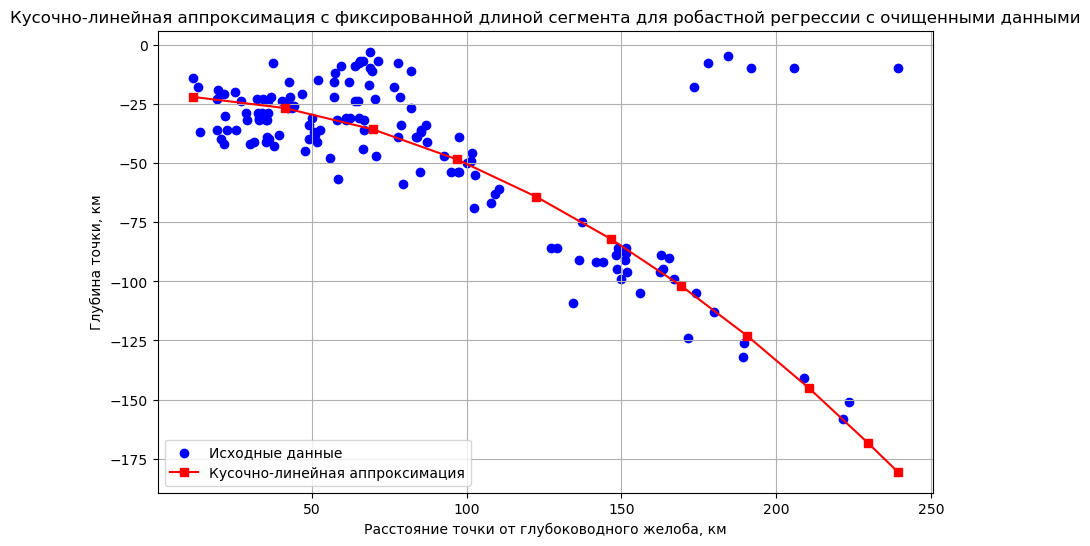

Угол наклона сегмента 0: -9.011881958798796 градусов.
Угол наклона сегмента 1: -17.550482390287566 градусов.
Угол наклона сегмента 2: -25.06128780911384 градусов.
Угол наклона сегмента 3: -31.66245322464856 градусов.
Угол наклона сегмента 4: -36.46909169714938 градусов.
Угол наклона сегмента 5: -41.093945505369874 градусов.
Угол наклона сегмента 6: -44.73016135190172 градусов.
Угол наклона сегмента 7: -47.87827370799105 градусов.
Угол наклона сегмента 8: -50.55396231959817 градусов.
Угол наклона сегмента 9: -51.80313408210136 градусов.


In [46]:
# Применение аппроксимации для робастной регрессии
(hx_huber_cleaned, hy_huber_cleaned), angles_huber_cleaned = approximation(X_cleaned_original, pred_huber_cleaned_original, segment_length)

# Визуализация результатов аппроксимации
plt.figure(figsize=(10, 6))
plt.scatter(X_cleaned * sigma_X + mu_X, y_cleaned * sigma_y + mu_y, color='blue', label='Исходные данные')
plt.plot(hx_huber_cleaned, hy_huber_cleaned, 'rs-', label='Кусочно-линейная аппроксимация')
plt.title('Кусочно-линейная аппроксимация с фиксированной длиной сегмента для робастной регрессии с очищенными данными')
plt.xlabel('Расстояние точки от глубоководного желоба, км')
plt.ylabel('Глубина точки, км')
plt.legend()
plt.grid()
plt.show()

# Вывод углов наклона сегментов
for i, angle in enumerate(angles_huber_cleaned):
    print(f"Угол наклона сегмента {i}: {np.degrees(angle)} градусов.")